In [1]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
import threading
import math

In [2]:
#hyper parameters
t_max = 10
gamma = 0.99
learning_rate = 0.001
beta = 0.1

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
torch.Tensor([0.5])

tensor([0.5000])

In [4]:
class policy_net(nn.Module):
    def __init__(self, input_feature):
        super(policy_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 128, out_features = 1)
        self.mean_act = nn.Tanh()
        
        '''self.linear3 = nn.Linear(in_features = input_feature, out_features = 32)
        self.activation2 = nn.ReLU()
        self.var_linear = nn.Linear(in_features = 32, out_features = 1)'''
        self.var_act = nn.Softplus()

        
    def forward(self,x):
        mean = self.activation1(self.linear1(x))
        mean = self.mean_act(self.linear2(mean)) * 2
        variance = torch.Tensor([0.5])
        return mean , variance
    
class value_net(nn.Module):
    def __init__(self, input_feature):
        super(value_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 128, out_features = 1)

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.linear2(x)
        return x
    
    
    

In [5]:
def get_action(mean , variance):
    for i in range(10000):
        action = np.random.normal(mean.detach(), variance.detach(), 1).item()
        if(action >= -2 and action <=2):
            return action
    return mean.detach()


In [6]:
#multihtread
p_net_shared = policy_net(3)
v_net_shared = value_net(3)
np.random.seed(seed)
torch.manual_seed(seed)
_lock = threading.Lock()

reward_plot = [0 for i in range(5000)]

def training(idx):
    t_max = 5
    gamma = 0.9
    learning_rate = 0.001
    beta = 0
    step = 0
    state = []
    
    env = gym.make('Pendulum-v0')

    global p_net_shared
    global v_net_shared
    p_optimizer = optim.Adam(p_net_shared.parameters(), lr=0.0001)
    v_optimizer = optim.Adam(v_net_shared.parameters(), lr=0.001)
    global reward_plot
    
    for iteration in range(5000):
        done = False
        observation = env.reset()
        state = observation
        
        p_net = policy_net(3)
        v_net = value_net(3)
    
        p_net.zero_grad()
        v_net.zero_grad()
        
        t_update = 0
        #beta -= 0.0003
        #learning_rate -= 0.0009/2000
        if(iteration>2000):
            learning_rate = 0.0001
        if(beta<=0):
            beta = 0
        reward_stack = []
        prob_stack = []
        value_stack = []
        action_stack = []
        entropy = 0
        reward_sum = 0
        policy_loss_sum=0
        value_loss_sum = 0
        entropy_sum = 0
        mean_sum = 0
        variance_sum = 0
        
        for t in range(10000):

            step = step+1

            mean, variance= p_net(torch.Tensor(state))
            value = v_net(torch.Tensor(state))            
            
            mean_sum += mean.item()
            variance_sum += variance.item()
            
            action = get_action(mean,variance)
            
            
            next_state , reward, done, info = env.step([action])
            reward /= 16.2736044
            reward_sum += reward
            t_update += 1

            reward_stack.append(reward)
            value_stack.append(value)
            prob_stack.append((mean,variance))
            action_stack.append(action)
            
            entropy += -(torch.log(torch.clamp(2*math.pi*variance*variance , min = 1e-6)) + 1)/2

            if(t_update >= t_max or done):
                R = v_net(torch.Tensor(next_state))
                policy_loss = 0
                value_loss = 0
                

                for i in range(t_update):
                    R = R*gamma + reward_stack.pop()
                    value_temp = value_stack.pop()
                    mu , var = prob_stack.pop()
                    action_i = action_stack.pop()
                    
                    policy_loss += ( (( (action_i - mu) )**2)/2 ) * (R-value_temp).detach()      
                    value_loss += (R-value_temp) * (R-value_temp)

                    
                entropy = -entropy * beta
                policy_loss = policy_loss + entropy 
                policy_loss = policy_loss / t_max
                value_loss = value_loss /t_max

                _lock.acquire()

                policy_loss.backward(retain_graph=True)
                value_loss.backward()
                policy_loss_sum += policy_loss.detach().numpy()
                value_loss_sum += value_loss.detach().numpy()
                
                for p_param , s_p_param in zip(p_net.parameters(), p_net_shared.parameters()):
                    s_p_param._grad = p_param.grad.detach()
                    if((s_p_param != s_p_param).any()):
                        print("explode !!!! ")
                        
                        
                for v_param , s_v_param in zip(v_net.parameters(), v_net_shared.parameters()):
                    s_v_param._grad = v_param.grad.detach()
                    if((s_v_param != s_v_param).any()):
                        print("explode !!!! ")
                        
                p_optimizer.step()
                v_optimizer.step()
                p_net_shared.zero_grad()
                v_net_shared.zero_grad()

                _lock.release()

                p_net = policy_net(3)
                v_net = value_net(3)    

                p_net.load_state_dict(p_net_shared.state_dict())
                v_net.load_state_dict(v_net_shared.state_dict())
                R=0
                entropy = 0
                t_update = 0
            if(done):
                mean_sum /= t+1
                variance_sum /= t+1
                break

            #env.render()
            state = next_state[:]
        reward_plot[iteration] += reward_sum
        if(iteration%10 ==0):
            print(policy_loss_sum)
            print(value_loss_sum)
            print("mean average : {}".format(mean_sum))
            print("variance average : {}".format(variance_sum))
            print("training idx {} actor true_reward at iteration {} : {}".format(idx,iteration, reward_sum))
            print(step)
            beta = beta * 0.99
th1 = threading.Thread(target = training , args = (1,))
'''th2 = threading.Thread(target = training , args = (2,))
th3 = threading.Thread(target = training , args = (3,))
''''''th4 = threading.Thread(target = training , args = (4,))'''
th1.start()
'''th2.start()
th3.start()
''''''th4.start()'''

th1.join()
'''th2.join()
th3.join()
''''''th4.join()'''

print("finish")

/home/wooseoko/anaconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[-4.9910192]
[57.812794]
mean average : -0.28243955988727976
variance average : 0.5
training idx 1 actor true_reward at iteration 0 : -79.8593209180779
200
[-0.3629622]
[2.1877708]
mean average : -0.15731120119336992
variance average : 0.5
training idx 1 actor true_reward at iteration 10 : -66.55600284635052
2200
[0.43703562]
[3.9890654]
mean average : -0.049467329308390616
variance average : 0.5
training idx 1 actor true_reward at iteration 20 : -46.57687658111274
4200
[0.04624204]
[2.8626804]
mean average : 0.058313553533516825
variance average : 0.5
training idx 1 actor true_reward at iteration 30 : -60.399554121690066
6200
[-0.03609268]
[0.8568086]
mean average : 0.3497794447420165
variance average : 0.5
training idx 1 actor true_reward at iteration 40 : -72.1665349474955
8200
[0.11584394]
[0.8807083]
mean average : -0.04306820640573278
variance average : 0.5
training idx 1 actor true_reward at iteration 50 : -75.41733225035308
10200
[-0.40555382]
[2.5573914]
mean average : -0.1290

[-0.13235591]
[0.9875481]
mean average : -0.34525396512821316
variance average : 0.5
training idx 1 actor true_reward at iteration 510 : -63.81810338736739
102200
[-0.18329126]
[0.66414493]
mean average : 0.18155390480533243
variance average : 0.5
training idx 1 actor true_reward at iteration 520 : -39.37122170556659
104200
[-0.24650626]
[0.8063312]
mean average : -0.015046750771580264
variance average : 0.5
training idx 1 actor true_reward at iteration 530 : -39.53826612568835
106200
[-0.20629524]
[0.6209327]
mean average : -0.19494436219334602
variance average : 0.5
training idx 1 actor true_reward at iteration 540 : -31.753287448883682
108200
[0.00752668]
[0.4200343]
mean average : 0.08491698071360589
variance average : 0.5
training idx 1 actor true_reward at iteration 550 : -32.34391506830904
110200
[-0.22217566]
[1.2596945]
mean average : -0.5688486775569618
variance average : 0.5
training idx 1 actor true_reward at iteration 560 : -47.78387841840111
112200
[-0.19617185]
[0.609065

[-0.00396977]
[0.01953001]
mean average : 0.2319327899365453
variance average : 0.5
training idx 1 actor true_reward at iteration 1020 : -0.10008544420092685
204200
[-0.167052]
[0.66605794]
mean average : -0.39875125702470543
variance average : 0.5
training idx 1 actor true_reward at iteration 1030 : -66.39362267066952
206200
[-0.14594218]
[0.9329178]
mean average : 0.4489168247207999
variance average : 0.5
training idx 1 actor true_reward at iteration 1040 : -32.77102235712916
208200
[-0.11691192]
[0.3045195]
mean average : 0.0011967716354411096
variance average : 0.5
training idx 1 actor true_reward at iteration 1050 : -15.667797148620949
210200
[-0.01132182]
[2.008261]
mean average : 0.12329796114703641
variance average : 0.5
training idx 1 actor true_reward at iteration 1060 : -41.12786546287327
212200
[0.04746157]
[0.18602914]
mean average : -0.018565488106105477
variance average : 0.5
training idx 1 actor true_reward at iteration 1070 : -7.858707054439167
214200
[-0.14872812]
[0.

[-0.07510143]
[0.67733943]
mean average : 0.49136153421830386
variance average : 0.5
training idx 1 actor true_reward at iteration 1520 : -15.784426897609794
304200
[-0.21139711]
[0.44546553]
mean average : 0.24975531741743906
variance average : 0.5
training idx 1 actor true_reward at iteration 1530 : -15.439006492215256
306200
[-0.14805536]
[0.9714507]
mean average : -0.1715787293575704
variance average : 0.5
training idx 1 actor true_reward at iteration 1540 : -15.606545015243384
308200
[-0.02433814]
[0.51742494]
mean average : -0.44423754705116153
variance average : 0.5
training idx 1 actor true_reward at iteration 1550 : -23.598729164651807
310200
[-0.04792659]
[0.3045407]
mean average : 0.48731656243558974
variance average : 0.5
training idx 1 actor true_reward at iteration 1560 : -15.927662932783711
312200
[-0.01547197]
[2.2723923]
mean average : 0.06154733965988271
variance average : 0.5
training idx 1 actor true_reward at iteration 1570 : -36.75407885849982
314200
[-0.04558815]

[-0.41886827]
[1.161781]
mean average : -0.1655590193439275
variance average : 0.5
training idx 1 actor true_reward at iteration 2030 : -23.666933912000207
406200
[-0.5636377]
[1.4870993]
mean average : 0.2553623336413875
variance average : 0.5
training idx 1 actor true_reward at iteration 2040 : -23.275093874469192
408200
[-0.10548727]
[0.457638]
mean average : 0.28091381482663563
variance average : 0.5
training idx 1 actor true_reward at iteration 2050 : -7.595536381495194
410200
[0.01329875]
[2.8723187]
mean average : -0.05659226097137435
variance average : 0.5
training idx 1 actor true_reward at iteration 2060 : -44.705913790722036
412200
[-0.249572]
[1.9085308]
mean average : 0.3649316747672856
variance average : 0.5
training idx 1 actor true_reward at iteration 2070 : -23.526393939319796
414200
[-0.05178959]
[0.3549289]
mean average : 0.06739460966433398
variance average : 0.5
training idx 1 actor true_reward at iteration 2080 : -7.614208356127434
416200
[-0.14865123]
[2.176116]


[0.01770325]
[0.06023785]
mean average : 0.1587065760209225
variance average : 0.5
training idx 1 actor true_reward at iteration 2540 : -7.883925654692672
508200
[-0.12082972]
[0.29458368]
mean average : 0.18214331322349608
variance average : 0.5
training idx 1 actor true_reward at iteration 2550 : -7.9078607076242475
510200
[-0.27482143]
[1.6794856]
mean average : -0.06028338839183561
variance average : 0.5
training idx 1 actor true_reward at iteration 2560 : -23.463136530784475
512200
[-0.12974887]
[3.2395315]
mean average : 0.0919797300954815
variance average : 0.5
training idx 1 actor true_reward at iteration 2570 : -33.265897695497685
514200
[0.08569486]
[0.406578]
mean average : 0.22468994034919887
variance average : 0.5
training idx 1 actor true_reward at iteration 2580 : -15.858464231074418
516200
[-0.02165415]
[0.19151825]
mean average : -0.44569961553555915
variance average : 0.5
training idx 1 actor true_reward at iteration 2590 : -8.037096701700682
518200
[-0.03405837]
[0.1

[0.02856446]
[0.6154363]
mean average : 0.7069489392091054
variance average : 0.5
training idx 1 actor true_reward at iteration 3050 : -39.96019186121992
610200
[0.0658741]
[1.9663067]
mean average : 0.16964372700313107
variance average : 0.5
training idx 1 actor true_reward at iteration 3060 : -7.270250860985195
612200
[0.22060259]
[1.4813142]
mean average : 0.21449392550159246
variance average : 0.5
training idx 1 actor true_reward at iteration 3070 : -15.192303535804692
614200
[-0.15317342]
[1.2144338]
mean average : -0.4110556734027341
variance average : 0.5
training idx 1 actor true_reward at iteration 3080 : -65.82121288810082
616200
[-0.18721104]
[1.2824569]
mean average : -0.2701010340184439
variance average : 0.5
training idx 1 actor true_reward at iteration 3090 : -15.198239505828079
618200
[-0.17900345]
[2.064303]
mean average : -0.4899085137899965
variance average : 0.5
training idx 1 actor true_reward at iteration 3100 : -24.77966111589744
620200
[0.03290315]
[0.31033194]


[0.00498441]
[0.3928941]
mean average : -0.3031234791397583
variance average : 0.5
training idx 1 actor true_reward at iteration 3560 : -15.913839048484247
712200
[-0.25039586]
[0.71553355]
mean average : 0.18945345493906643
variance average : 0.5
training idx 1 actor true_reward at iteration 3570 : -15.667495915036197
714200
[0.02621969]
[0.75638914]
mean average : -0.1592368165892549
variance average : 0.5
training idx 1 actor true_reward at iteration 3580 : -15.84117763085377
716200
[-0.23180658]
[1.0016966]
mean average : -0.13359053240623325
variance average : 0.5
training idx 1 actor true_reward at iteration 3590 : -23.707665927614713
718200
[-0.04331326]
[0.3608208]
mean average : 0.029559206068515777
variance average : 0.5
training idx 1 actor true_reward at iteration 3600 : -15.526712259556552
720200
[-0.07778064]
[0.72587407]
mean average : -0.8163015855336562
variance average : 0.5
training idx 1 actor true_reward at iteration 3610 : -31.74677947988363
722200
[-0.11628739]
[

[-0.13362588]
[2.0787427]
mean average : 0.06713064569747075
variance average : 0.5
training idx 1 actor true_reward at iteration 4070 : -14.966153319536316
814200
[-0.05358264]
[0.35479128]
mean average : 0.04768723324930761
variance average : 0.5
training idx 1 actor true_reward at iteration 4080 : -7.872837339455017
816200
[0.17595208]
[2.1815238]
mean average : 0.14619737523025833
variance average : 0.5
training idx 1 actor true_reward at iteration 4090 : -15.746661971405084
818200
[-0.07564154]
[1.6026804]
mean average : 0.10783996370155365
variance average : 0.5
training idx 1 actor true_reward at iteration 4100 : -15.130929180815462
820200
[-0.08746888]
[1.0874594]
mean average : 0.1668002254841849
variance average : 0.5
training idx 1 actor true_reward at iteration 4110 : -15.828443461843488
822200
[0.18113646]
[1.8563526]
mean average : 0.08934628910967149
variance average : 0.5
training idx 1 actor true_reward at iteration 4120 : -23.815804818773213
824200
[-0.08925693]
[1.51

[-0.02107326]
[0.04759767]
mean average : 0.0965225260797888
variance average : 0.5
training idx 1 actor true_reward at iteration 4580 : -0.07612158177475008
916200
[-0.27431107]
[4.095679]
mean average : 0.1420591545943171
variance average : 0.5
training idx 1 actor true_reward at iteration 4590 : -42.103688731926795
918200
[0.14261398]
[3.9103637]
mean average : 0.1952001466031652
variance average : 0.5
training idx 1 actor true_reward at iteration 4600 : -34.051055690853
920200
[-0.26235196]
[1.8747001]
mean average : 0.07989940600586123
variance average : 0.5
training idx 1 actor true_reward at iteration 4610 : -15.30373248941546
922200
[-0.18894778]
[1.330268]
mean average : -0.27186602004105226
variance average : 0.5
training idx 1 actor true_reward at iteration 4620 : -15.598685103777365
924200
[-0.1399812]
[0.9220869]
mean average : -0.025955157751450315
variance average : 0.5
training idx 1 actor true_reward at iteration 4630 : -15.522816722689738
926200
[-0.08915111]
[1.28759

Text(0.5, 1.0, 'reward')

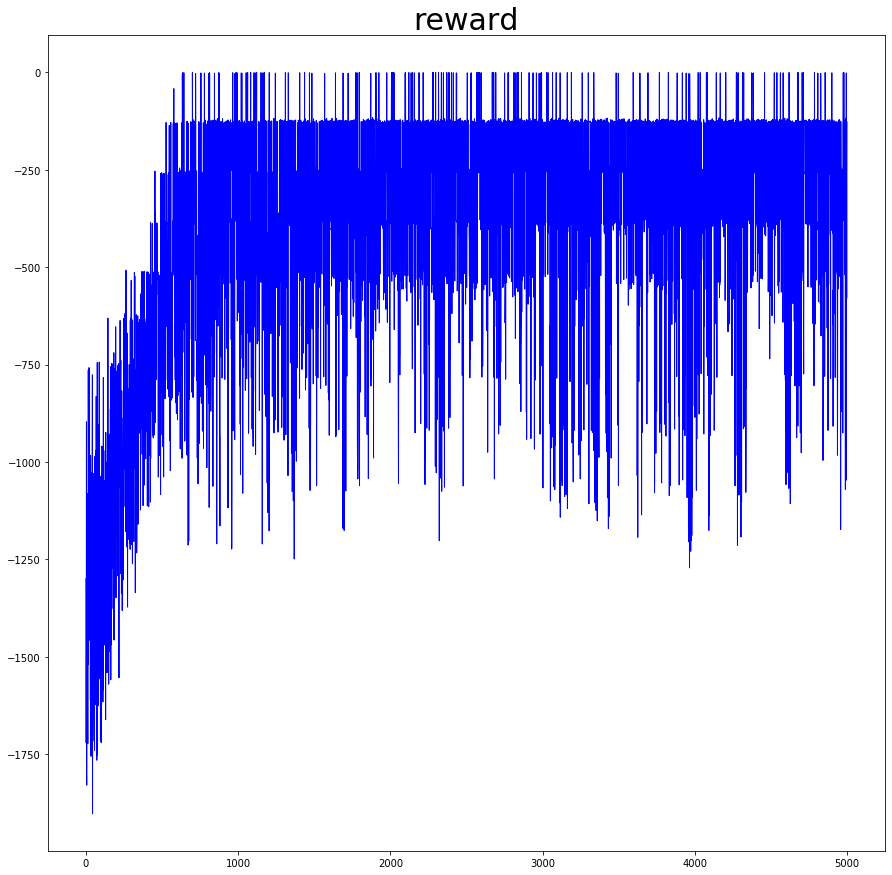

In [7]:
reward_np = np.array(reward_plot[:]) * 16.27
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)


In [18]:
#test
state = []
env = gym.make('Pendulum-v0')
done = False
reward_sum=0
observation = env.reset()
state = observation

for t in range(10000):
    env.render()
    
    mean, variance= p_net_shared(torch.Tensor(state))
    value = v_net_shared(torch.Tensor(state))

    action = get_action(mean,variance)
    
    obs , reward, done, info = env.step([action])
    
    
    reward_sum = reward_sum + reward
    state=obs
    if done:
        break
    
print("reward {}".format(reward_sum))

reward -129.9289420311373


-136.63675966094866
-62.99340299692854
-122.01290586201303
-6.780256739908512
-22.390323933783975
51.28925764793655
-94.49473344986305
12.814250057950675
-23.897393824553383
-4.449367089426244
3.917371432745435
175.20713666642683
138.13450854416516
15.310171681840107
-63.90127771924365
-250.01546507430587
2.17139724318832
189.73036131357844
-28.159584187747587
-24.854010084010742
141.94942338238135
-131.2382340690033
77.74162072597804
-135.50283796721183
152.9553666164505
85.85709916312663
-127.43216109112052
107.83648285535772
-125.12010921815259
-88.92016898755224
-26.973175148726767
5.89282633401744
40.50301943653374
112.42442814289755
148.55363514353905
45.68535376644156
49.825284759449474
-163.82404009268546
-80.44009898500478
86.78694736829372
38.401672032410204
-96.82015168092047
-66.69218365820525
-17.021643503284984
159.86316305613505
-133.25045004423038
78.43720907706056
-54.5142991015243
46.93005054710018
39.02080801172942
64.11199229015388
8.35427720268708
75.27127045239098

-43.662747769585955
-187.2728468155837
72.69302948537697
39.47071283799243
148.94289307648626
31.662472888901178
70.34999712062512
-26.338775258567598
214.09400512369848
118.58943976114577
55.13181452633194
-154.09601213112225
81.26968869287525
0.9696079742261964
action is in the boundary
-81.46411288155136
171.66393637364928
-58.25977371134561
93.15496898906429
-103.68613600678206
-186.11760719250037
-12.511266184431937
-154.68535570274517
41.331160422867356
28.54710268751562
50.20006345103428
-7.559568826672987
-91.51854315937578
37.32974496079627
130.3300598212399
-103.08787933774151
-11.880948257561386
-115.90673682854155
87.21620304740013
45.34541520906163
-21.54581608065589
18.647873536392183
156.9819361567538
-118.03646297331652
83.02585735193276
114.24805023659685
-59.19868902138663
7.553017905780861
-18.373018858104974
-66.91847279288797
60.611410727769325
-120.17082659776779
3.7510853860184907
118.48765075229808
-191.90066937914673
-44.36054053923835
-3.4533829954972872
-126.

-34.279274448369925
-36.34673245967001
46.95071708396855
-127.20712528145664
-6.66736742834361
77.8795451274668
19.705473632899313
40.60705750998847
-30.561255265538122
91.94005957332892
-7.993849059952282
-151.7339159635887
120.36818579398796
-84.48532034505845
61.01567405292598
-21.98850837080377
-60.52800392663064
-141.31574912180574
-54.93706136336248
160.31763540465994
34.55432230320574
89.46141969828315
-24.45844075263332
66.35381963819626
14.28293007184702
82.94625716302309
29.732732536944738
-122.84684712013956
-65.927426338878
-7.372478956035581
27.336007199697733
65.31319676034218
-15.452147508958639
-119.52283067387852
-19.002955093251934
-184.336231977399
237.2420907085255
-91.02217062676297
51.57039528850511
-145.3877505209547
-19.6666959463615
-72.95877522979795
78.53760134407273
55.66681055807808
-97.7711856254272
101.64112944189792
-41.22195082916312
101.95582787965252
24.48258495864504
76.78569162774642
-56.87414760526954
-67.63151811988051
99.6581697948263
-144.028411

150.9262408806681
-213.42128537183186
-80.6443647922688
78.11827986843959
-3.8582812160068007
129.03031296406118
102.68663919522707
24.285462427716194
-238.3315059625477
57.91995197377727
-166.04554933884782
-156.97773142034464
20.33874525129977
47.03757567690677
-126.61476464969452
71.49001164270142
-115.92235560419826
19.404563929663666
-46.95008691651142
0.6618041632942996
action is in the boundary
-66.52991584848778
-215.20521644846573
-230.71051196500497
-44.12190910798168
-16.64155918320714
-82.37511089015015
-86.79168148713102
-57.10204761539899
86.81100502405596
30.8710278478605
7.627587047339253
-71.07750436119689
-37.5836562385103
-82.26331137399036
87.76179211283757
26.294265098880487
44.82048886254762
84.72998020349131
118.58550880516437
-16.90368519798419
61.49084060853538
-2.5298182403949196
-87.08260227597448
10.218031966118524
32.00754932056467
-8.748838754271352
86.99757853913327
-20.22566116804276
-242.87021056326873
185.4008669729669
52.888942383964746
147.0091681305

8.892720380046185
-21.028535504180727
6.964002723734778
-45.035055774396206
-22.364520879815665
-32.53004136842191
-131.70476042192936
82.03655679690026
-58.58426813991491
-84.60643437593015
-23.17424290448211
25.81741187942691
-174.47051034905414
96.3430789682477
-29.421289873285435
-28.813679374656783
58.683174669446416
71.5050839357138
-59.277985532047126
67.05107120004618
-0.1299277339572615
action is in the boundary
-131.34988416439722
-54.94469530867572
-85.31954409526158
-59.715233730678776
19.78404629282186
-71.69712111188906
-57.402978651122474
-120.33835975155131
81.77158805598316
-3.4061417223392794
49.51497199283043
37.10620829237137
-91.68458697279227
139.1381320591695
-110.99919090294448
261.6808968104799
62.716417239734554
-19.879549123632987
176.4579703577493
10.143953623356236
139.32273097713366
65.1191378526025
-106.78500606417268
122.33702321385493
20.05617218912005
15.590569395328584
-23.637917334741367
-189.08347151723544
-210.09198010422935
176.16163443387282
-69.

-41.31751700878772
-44.47876047338832
67.17475000416259
182.61499704516103
-81.87199454286112
-35.51759888509201
81.07855070695297
-98.4158093990586
60.31303396769415
-119.08758609064705
8.545837503256868
130.32120180803804
-81.56083741053178
-180.40463041575256
158.60339797722597
160.8369955271064
57.23361959563675
2.0704400683690474
98.34161482576216
47.24008021265732
262.98598042524526
66.21814620076151
-107.51333334345401
-50.76667139644382
74.39536230474916
169.33564130315278
67.38202850626391
42.70688804478569
92.93743937457128
105.4378379390243
64.13189860752541
11.59451496467942
6.239738312869314
-9.670871103695081
-62.252057776337885
-108.70009252103571
189.6320637309492
-69.55523855148758
60.41192482163591
121.14518737484926
-30.318063668927802
-10.644016458946593
19.628404625573744
-19.100108806076843
86.27552767031
-76.69746093595528
-122.15652560698827
-44.99583218077151
41.37960556222323
0.0820406405775427
action is in the boundary
66.18670386764937
-91.5728130320478
-159

73.40818423852741
-63.44663981602234
-45.99445416154262
-26.447737810896964
-108.02420613619799
172.1043232212623
-41.09575244535632
-131.1681470323375
-38.60435114542563
-71.82316962204432
-32.52613022762149
-138.3793552533507
-10.696490935327239
24.04002233553646
146.92861037298908
-30.166211075361783
44.800429007179964
30.80774419969794
90.91842831622293
149.4095316134802
-5.604384495372663
-41.26936869523203
104.71391590733106
111.73926770089395
91.9865904455077
30.7321645650666
-196.06312073607867
-180.8177785133673
-54.00503956060805
-29.743739004416774
-45.28408940707516
-139.17674543785674
-25.12972069330007
-19.589845238533915
77.90441318176433
-46.50100478965992
34.90807535309108
-11.798851371588666
-4.464724016629662
5.089212979834352
-116.28328187855452
51.51474447387406
33.335146768047345
116.4439596868972
170.6289304717817
-170.50752532967118
-132.6236485119505
1.8473185268338206
action is in the boundary
-49.889415426115654
164.72829088224972
145.52157051124792
97.397464

-152.86527898636362
-41.975645327616846
134.67879226436145
12.943113935842627
-164.76468184307635
63.539107752170565
-58.929586334311956
55.741539468827185
-42.4672771225466
42.818445209735756
2.175312790269862
-140.30124027547149
-79.99563534900574
80.64533109043886
-25.703539010096048
-151.99479151480634
96.5255110631593
31.514255860069166
167.30028230628596
117.13156045395074
52.931174486432
24.856260874211436
-19.249296191292462
-4.823317552347024
-154.43620451410504
28.495599857196257
-73.14318632355268
182.60939976866212
56.261897208090325
112.8472760504267
-49.80690932027793
-48.8239947191275
-245.69611490738535
-67.63930642376799
-23.91926542290435
165.42242381618004
-24.089612111524644
-0.028518989968666104
action is in the boundary
-35.62702166479158
112.11389080768078
-7.333757904750521
-55.91042391080631
-174.0426572665646
-58.6319616685119
-72.32232723964613
41.721852139184776
-11.203407106170479
28.283239265253325
192.04855176428893
-164.72928796793545
141.1822088552364
1

134.38020715166718
-35.51789720683234
-30.75451521149545
-119.31387634238348
6.865119697018436
83.8878737533751
213.05938088236275
-138.9265867861644
-63.92055134164952
43.36514425045553
-115.10524440610972
-17.6552528054
134.10343686836822
208.28633143253293
-123.33851401950844
123.77984516382521
-112.39933769085391
-162.37114190132596
-126.88391735163313
-89.18171355483904
-83.23787218905771
11.301650452066994
-83.70900765830037
-11.218649515715864
-110.78649461418799
105.6131657401864
141.60441428055708
-120.12859045070459
-132.8116479118849
101.03607732164429
-204.35928811822106
30.82965347741784
-247.72424728301877
121.01135960087161
34.2812062626484
15.933946047490416
-117.24302163446276
4.25077958846249
9.772802464584785
-40.74806552859966
-8.554763467071664
-40.64266716352007
-28.05276496021603
-87.39262555074774
33.33232386328189
14.987221366969283
161.89465657096846
99.95901127447019
2.4177098510131456
-26.496063901543852
176.27245192333646
-107.08379940651263
26.301279036076

-49.798078219418976
20.02880450172261
87.46134886228648
109.75513049250071
2.1290862428881825
64.22459985706855
-47.349594136655924
75.3871327105384
-42.60587403380149
-35.434078914542674
35.022093172320595
-64.678199060868
37.13840841040579
13.891473123388096
-75.61926961295273
-40.59438841195401
-13.3652846216431
-82.3379231257069
-78.6511876649437
156.84711589678395
-80.19396698962517
-12.311331958274325
19.36888928543151
-121.01446668337026
-113.20587915171747
42.8602486567851
-173.2609538008293
94.44385109307716
89.31303603867332
-45.80471069819948
25.44525246820946
67.25242916147437
47.35999640930937
-156.08678817655027
-95.08390624463128
230.70347209138572
16.800563363104086
327.5656789063183
-91.88757455037991
87.82698524375854
103.75472992111587
155.6150132714933
89.86064403149746
-20.22255493349008
-35.589848942604604
138.77950035348812
37.53181780398213
-120.31131296408348
148.33766226430916
109.89162693692343
-50.54807335903651
168.9092058723984
177.07720400577452
-90.78540

23.419292205476168
34.04817051933098
-133.48891673154958
85.1442213200325
41.68875438747504
21.485963081401582
-171.24514816564965
-204.50339518271267
-39.029713566385375
-18.68673373089382
-28.509115879520834
146.956190231703
-224.65882596146233
41.31351278292133
168.0281432062447
-78.57611010488526
-195.19297328888214
-1.9869284271015353
action is in the boundary
-11.088779813731042
156.532229499335
-0.4853981430539882
action is in the boundary
50.725054620439536
69.61855952418446
-118.52617428604432
114.35117448045136
-111.51496826833063
-130.34971368048636
-79.71675330854082
136.0774159944889
21.55787745532363
47.80744535929829
7.41270708912163
21.68171187659191
117.40041437971291
96.87658850261886
115.8774952413444
167.24369387984197
-33.32064265019266
-41.144787202315754
-63.19389483087912
-191.57440614787808
-87.50611234694878
194.80921405639688
-18.396186444600595
144.84926551674906
89.88718856149696
-23.654377703283018
-154.84681996180956
113.66415380440469
78.88231602571969
-

9.334151735596619
-24.481088988955573
2.8623463329835177
-1.310730196562755
action is in the boundary
90.8147745466748
4.300791725742332
25.236201858045238
-109.05549980151976
-152.27371707043315
74.90064579860316
47.98201461713411
30.70833898466894
131.19020426538845
-20.73581747524864
-85.82750527804825
108.98526178916742
212.11269404200843
72.12485817815684
-26.84461335380905
-17.155116253962436
2.2739149204657076
23.21609794530363
-145.84072337685006
-122.27839226432882
152.6523966297062
82.24034090601785
90.78652536543127
-9.608520773897478
-86.39168949361054
147.89792178572395
-140.46294285049962
-2.6185467544225465
13.73140620757689
-104.69630828716905
126.46259039673846
52.88613477711531
-243.7451630531045
103.95305771810344
63.77688442979499
-39.49514873422552
34.721695172500766
-77.5580341817859
-31.166058842716254
-53.56213485957523
26.549751788793706
-73.21183275364925
-53.504997219740844
130.3732766696091
12.688139406764886
-141.32344105194053
-15.017807727372004
78.979437

-130.70767111555799
72.84053712302685
130.0759565580795
-263.1035785095444
0.2931576251000911
action is in the boundary
69.35282088693148
15.203591691864347
-28.199615249915173
193.17476767102266
-19.94708691847252
-2.0877082657139256
20.950469249971203
-67.9714410936822
-291.7069018116665
26.566099893461214
-135.72284579161874
-81.4391525669069
88.38454575399895
-61.36246212734543
-3.9934255075865193
33.5764880498462
-83.43001141940273
-35.353472878356435
125.66658994801938
141.83047683108714
-173.6804922867823
21.772191292448614
27.905554184865245
20.162825301231678
15.063963862440918
-15.04184499541083
-92.84584198420153
-135.9357203302872
-20.097087646217208
80.05035469615572
8.186160470575718
-69.68912504237366
223.688024252806
-19.346262452001735
22.79084847587271
110.62620313338903
155.32666337234414
-37.103664018085944
184.39859912318568
-144.0669511653696
50.36166088137344
119.47462730798509
-61.89269619436012
54.60784198101639
-4.514538829376987
-24.693702475867934
-7.9256719

-163.33711099891138
-35.54468357079747
215.83798891473225
5.8226092414481245
-27.940146372774706
-142.947286218014
26.508671503932323
0.9543680736198434
action is in the boundary
-64.6209244630892
58.048858297691595
64.172617473877
-33.02094143022107
-101.9071856466401
16.603993127787202
-25.087344850355674
99.27217815278425
9.35339227432295
155.44285465696294
-85.80717575104528
-37.647951583626
38.56652055610762
-212.9434523664668
18.097568516283815
-57.59803346238055
-104.08370085128963
-9.905507638014742
-76.12674860291337
9.767011895711205
104.64248781477184
-50.923164272817154
213.53837056029508
12.163985538941509
-74.97830760350291
-51.969495159713475
135.83182441770424
-38.803621772785014
154.961202547895
152.51008291514023
203.43118579947438
110.41545201136398
-13.296353949662421
34.614898913433386
-65.70255766531498
11.802362162303663
-140.38611393058721
-17.95555507464514
156.5434342404354
82.14383060798365
-125.58570437503269
21.066248666584443
-83.17788087511518
-167.684404

-18.655878014538466
-26.904276206597793
99.9426955847248
102.56919876551297
-126.53522471615399
-72.2732350825782
153.6852382343812
-63.32413594502739
105.45691757065173
9.74563805838998
-43.490599367682414
-56.80712752371414
123.93364906369628
-32.86715071454874
-126.56834841160871
10.45416577418419
0.5531872982868359
action is in the boundary
-110.73282631758865
70.09304385164987
-15.840160311541496
-78.33072846471406
18.700508786016588
211.8000764520518
-32.39216102556392
-32.05193899274409
-101.79380595156881
-111.45455198084824
-14.05988561093623
-20.60939244395196
-71.10358703984167
30.62552993476665
50.33412963477459
23.961763054916123
27.567699730086225
71.721919440842
87.20916707713302
29.655371393122838
116.5483861995678
157.63045554698542
-28.23555396801762
23.624669669460427
-55.67120927922324
148.0836085016468
92.78562244442557
141.85021129809056
-120.26960148918324
-139.27947504923287
128.80889576623522
233.30303908380117
-77.03373931008942
-17.496481220510415
-156.667287

-71.08841963073132
21.814134414207302
-11.664277319885672
6.024021631306303
-33.07705608017358
-56.60025923213519
79.33728242830036
-7.22106693085762
46.4461162991017
52.86270449449737
9.636413367515276
-150.31048281568908
50.49498649753752
14.919563135665292
198.30945196308014
-76.22857184528544
176.71634369359478
-44.15273256918083
-33.37330574121531
-17.979442794042267
-113.19009343712018
-102.1216530207601
102.59183991351655
53.598621059301784
89.73143065084294
-111.84369794698964
-14.389875997614945
-43.07033416740519
-54.96314964350785
-87.36148860558853
50.32778600608048
-257.79603468618734
26.870688998406056
-44.75808468773915
-19.762248283984505
-68.94701047340169
-47.06557820488453
72.71976318696754
-82.9022237984204
207.59740275782318
50.37667722848159
20.187106682735564
34.19546918669528
-57.113855146093016
6.789886887388681
1.2772427623197136
action is in the boundary
101.25731433276115
68.31927112344366
-41.466581200916
-96.4252186468523
71.87963680769684
128.841789635849

-28.73731748483992
158.08977574069652
68.6906224385616
-75.68422601782669
-41.76026217858846
47.4494960727674
60.65618359883685
-65.38414915723052
83.96107672187071
155.01514562419328
29.51641839794192
-83.90865006130961
-91.97103306008032
1.848803055822868
action is in the boundary
26.628679048775844
2.9732934317558897
-191.25240248899826
104.25967084412096
-16.198294692978195
-157.69400690882162
21.541637226371215
-92.8083800838986
-73.6885165455153
-47.6425608271293
-2.7612613227603506
105.2174877000833
-18.333118694361232
-167.01409386865257
-145.65003690374385
91.74960378753718
-49.295710133051365
-171.8193138888689
119.94909685273552
-17.315163343948363
132.4299391434192
4.214654655123366
-77.6134236315943
-53.604611711211106
-105.18597041709134
16.45068207385989
-26.46112597777725
-188.1308536346857
314.6675941643338
29.94758148897201
215.76838526794964
23.291110774359545
-18.783401557950206
37.38841763823018
53.35652656350912
27.01267114995621
75.32193541272683
-78.102040512178

-149.17793081885503
66.57687860042259
-6.479786148080363
-114.01776666258003
-44.71151558306261
55.41283234664975
-85.51395416546247
-49.007485512626985
2.0688439334346995
-138.10348072709
82.84802207259003
-237.707757107429
52.005470229852804
33.05145902126135
-153.39628375072192
100.85409138546983
-82.15002289774928
-58.141217067567275
-96.2433882338334
30.24040478288301
134.34710816149544
-41.581534263201924
-63.2707337483715
51.729974924232025
-87.14678155260866
-41.518647374691156
-149.20741271779494
-54.56588793146309
-61.125619656558484
26.52585841064815
54.983088515107745
44.52776726433551
-39.95448435672945
3.1724925431116677
-132.33117824336213
-5.416413701533534
-69.26902388003573
83.78027714121009
75.67278649804496
99.39099836968421
44.02177749497729
55.425719703492945
45.93739297103304
-85.5080968602666
19.077036260535955
71.86447626615411
-3.7822188182170056
-132.53358281105562
119.02912698948585
-91.12887552320656
-168.59268746341033
87.13287403214882
-87.78043064141151


-110.11447110512526
-110.14192318955429
116.94210600820689
-94.58145636603258
-72.79786797088484
157.1983478984519
-64.85329039225938
-111.94878614067679
82.84924447134325
81.16439796887087
-78.91255675837607
78.02680286405239
14.817854646480487
-40.00118117132628
190.99210947828084
39.54741919451556
46.196064042965475
35.130905239999066
5.105556174119372
95.6262163894395
32.22159703150363
-113.79959219075376
-105.99081185207928
-128.64003266933207
-4.661016319092486
-91.34064138289433
169.04300442113828
-6.867788087000641
-54.13306810840302
-91.02806539186845
45.334282516299176
-4.0297922653231
78.13613507018788
12.820097019077172
-37.18886502493094
-79.19956715945014
105.80775941949148
115.0362271183307
-196.2981570862778
102.0259157655511
86.12397744833198
-67.60752611237955
37.65127083978499
-34.939270283203385
43.85912446864085
52.72941443502134
80.53526199046966
-184.0977827262389
-4.0279661918371295
106.1634377325999
-130.3366153950688
49.07779998302655
-62.320580575350384
85.65

162.095280538232
34.06496769504761
139.09510740986494
-35.34555120440089
-53.43473447454438
-46.88666758041579
84.84239517378936
118.55330186448847
-40.82939899731039
-54.99552610754107
-134.80138092226207
-120.00389852629394
-3.912700572229814
-109.44810841414458
176.74443018083284
-37.39526146343235
-22.145525280621676
92.89975579807749
-92.40428841943938
130.61057448359554
-101.0155720131086
3.829351337376532
20.345360380115572
-4.096090008097278
19.703423080609273
136.86472572213893
162.93186238090738
-112.79024082154932
61.49061433853916
146.03671563716762
-9.343776927784784
-38.21307513909852
79.11322963734307
-140.13964508747378
28.926091911520125
-105.63094255656137
199.3431705075172
-231.74360803916673
7.003870807842144
63.189533763561215
-34.74653496412862
33.56274118558126
72.1337271665517
-176.12898881359897
2.207194664716265
31.171493282103075
-86.53316803129407
-73.23897846666664
-128.3725310265821
-54.09080843026636
87.49940302268439
47.67025119418957
108.19052583754716


-22.884438808703532
-156.4233423644406
70.48729083932842
-74.55244847038183
83.83914860289316
42.91630232184108
14.467574612018138
-168.65848801438636
76.62502275361159
-46.55173436891305
169.52605423167432
22.38666331837731
63.94176361381842
86.82650038679029
-1.5085611744967695
action is in the boundary
148.54366133137484
66.06489000808375
-91.96397263853846
15.181059457856886
-99.99151642938632
162.16219752300452
79.97524810017133
91.7797014459971
77.0908429615879
237.1097969607393
8.660135930618374
-246.4378758157502
28.41730469320144
10.80975074509869
73.90434609636742
-44.07450714887663
-86.76593932215442
-81.53185353357408
136.40142083928873
70.23289787775599
76.43575087908582
-288.7109748938913
-242.49205835491043
18.17006777136681
-47.37048807188008
-79.71814030629984
-25.828297492306213
-42.250902882016376
-88.80211367284903
46.85573932324404
-105.97199266034121
13.4601510057294
14.479774247334184
-10.514571640995587
-137.52790095257845
30.274580829708047
-14.67087096201046
1

-93.3443192875924
-94.84236958448264
23.746546419424806
54.32863066986824
-89.46783698989688
-169.950076868342
62.3879806999514
-112.28431036142163
96.18027962353463
76.28370640806375
17.416303225553044
-59.57941518049865
34.79145869742041
50.87880976928646
-14.851928137588017
134.69350172803306
13.950379325522396
90.04213950976701
114.17689107211575
56.74550724142774
50.32930661275942
-100.84077659551596
-65.55861704325218
-93.20606939976899
-56.517428900408994
-63.12211826591525
100.50007033560952
36.29162226142922
128.24354732396245
-43.94893422332339
-2.9435265994945206
117.58148105759125
-109.52466416724374
145.81762521079048
-131.9112735552656
-61.85985890629739
-85.97085867201419
-42.92153003231647
109.79925610511985
-53.02342108979501
91.87792549597418
71.04192325519197
-5.173184555771824
207.52103059159884
-184.49569257516768
-73.32951350870708
-15.960735557320877
57.288296156804606
59.91125093536076
-154.02027840719467
19.693019178623754
-156.01651217753323
-85.27770705704087

42.75318078032648
64.55396635252238
-122.59789157557248
-99.20643990201796
96.67425225967735
12.692033486498847
89.22578024553297
119.2101809479995
-143.5406836610126
171.36521216324442
-33.817920429358864
-148.70525266657768
-72.5055866922843
10.912507838832544
10.41899422870827
55.18624061058718
-48.55382061109246
69.08018583158028
28.423227383073694
29.254364954537802
-117.24759470014948
98.25181838567713
155.10891373198595
185.44579707017462
-95.10554422434465
-120.22961995302683
31.581650708498145
18.695740027840337
-188.89240360733496
122.25022919716146
-1.3304459483285644
action is in the boundary
10.877982971428022
92.60287939273158
66.9990363482165
-76.7017081846304
-246.967860571411
-46.29588612879809
142.46380125707424
191.3596541580964
-43.586004824616765
76.15160068162355
88.33686152282012
-51.38481126610653
15.959497823059218
-78.65958778182909
65.43847565945964
39.194582785347116
-112.75710790732423
-82.08612196320402
127.58530684704081
-25.779532091393527
-0.58326839210

-9.613968890096617
105.88095039945725
291.0726714962423
63.67284003680371
5.996877916055054
21.803865341552637
-139.29996474277607
155.53906400355336
53.82306893030786
87.4977215626389
54.33417125591426
43.43057191708833
-65.50531562720975
-31.381976470628675
85.98305522895797
84.2521273955818
-204.26685751984905
152.53674706768703
-11.305751823192017
137.72853917285872
47.81495172428986
21.04881151157607
-65.35851566774811
-175.3774399239803
93.3907497243668
192.84099456375304
-25.32489952754145
50.85514508611987
-15.253145230529139
-57.48647281061119
-104.79291949550932
-173.05422856316815
-98.90281890818169
-55.51772956963833
99.65543110380246
58.20851909991184
34.72667553586439
-47.0067651116856
25.316269230717463
-92.8514169416831
-10.58493975161437
-87.10616521112776
-8.61388660736636
-7.9844498474580705
-64.3371085063926
-59.108961850317364
26.025784690252664
-73.55833906659818
87.03070625857995
-49.94775164849296
45.19015675298086
84.16972665192138
61.137619836175915
67.8102958

23.062464726515415
-237.80653654508774
55.73035571480459
-183.70164313929192
-24.75546481028091
49.49752833793969
96.20246123182784
53.41964703270767
-36.56743703122676
148.93182773482067
29.272928854181497
215.13970568310964
136.44162174249647
-25.800438017580348
84.84618768032632
91.43042360742088
62.80139609416603
-2.8448766390344793
75.47525351765174
55.87560700647942
72.44501662720793
-168.01989286451402
143.32498056840626
40.98062611957735
-24.791184938181384
70.68314470557088
37.49242563598706
-69.10637778067766
-76.25628009098591
-139.42234009497952
-41.246376337880186
16.321216213961705
36.71171570938259
-110.04287927226511
-11.568431245430904
22.980913585231217
44.28013417780307
48.58699451383857
21.67729750048137
13.424972312309826
-91.1234752102487
98.21123525390016
25.226238157519543
204.0905771964101
41.201574529763825
25.355686896942565
-113.52178814332585
48.2333478046662
62.15434427672986
-63.20888323508845
-28.692477274712797
56.05573463064686
163.2131595075708
32.114

-117.95546405710937
14.925319668527756
-49.5404038548281
19.42689188938892
-6.348243252064864
-107.46802821316159
-61.18492137479328
37.470559441020555
-38.96427780429997
135.00211031869352
-56.877356035772465
13.56256985528182
58.505708573471274
-86.4482172002289
1.8147820973326216
action is in the boundary
51.54860973116231
-22.297200251973447
58.95297126667535
-130.9928831783398
18.690311582928747
0.6922783935485035
action is in the boundary
-27.217853905839835
-75.48512482449121
142.23713263149534
-43.03656751123125
179.87711214752244
6.214005449081166
144.48635691772284
-57.89131992245458
-19.129250094731393
32.61549013882705
-265.97477177222095
23.141543580041137
-1.651918222058198
action is in the boundary
51.89689179491776
-201.10181603891144
195.0525001121568
191.4717187559123
48.113603052367154
67.45087285936478
-19.34201845803222
-21.83948215163306
-16.73108729593564
110.65198525916948
145.41710922557795
-71.5893930972135
-15.00400031880747
77.99752898193661
-153.99924936910

-20.305702981602806
1.9908851059517383
action is in the boundary
35.80150897849905
95.87842933487742
342.5853284334846
5.193685305410127
-40.81283363790878
-100.25301344016376
134.10090624632062
235.3550216758752
84.68417564816669
-44.190318898272274
-125.48924527611915
20.84627583252204
30.510226261110958
-40.31075792925517
55.65217260760627
66.92704945237978
-22.683657146135978
182.1472517488909
-77.94894654072752
-14.675334571277643
135.4216127989148
-55.31211386580341
163.11582258983105
4.3121864887440235
97.33018128576435
22.02529019249417
-153.64385474559242
-139.6235014040075
-4.894175725134687
153.79772025881817
10.004806785010492
-46.97624908683539
147.21847257694773
22.123561003571602
-22.718437809266113
38.71676753249929
77.11169414684723
11.922687286191927
110.60694077535098
50.8645473970556
37.05657127039134
-98.06263876276421
-118.63067744265466
87.70704056220097
5.732254118961277
22.09402073287508
30.585348313917134
10.381137365200852
-4.773969482878066
-56.5507003041077

135.51636684974758
21.600336871293553
-185.9032963937995
27.967257443751535
76.740506621357
158.0830818169603
-37.942014867771896
-48.5826815982554
24.413378766874665
99.99722947012407
-9.115617784981008
65.20215103841288
-66.05067854036099
-85.64846164269049
-47.162367678835224
89.30165895379247
-97.13786026267861
159.98302159088527
-29.541802695826814
-121.06459044008267
110.70250642542652
-158.02506941724002
37.95338434694292
181.25517117062856
201.95017654614736
103.87433661146217
-125.2885327879791
-120.11553829121901
1.0742191307049838
action is in the boundary
-18.96708912527835
-92.57180074733691
11.881439080769983
-69.99198480106105
179.85273879448863
24.984991262733875
-4.464798451444887
32.441479408272635
135.37200185338799
-64.20950998777492
-45.62624434509069
-168.8810532578714
41.731780023575865
-100.6298345552344
-172.77052657658206
101.33173618559017
50.61763045346175
42.36062962091633
90.71718724548775
15.59919513626276
-66.66157219022433
174.30045346596256
51.93795123

-98.45299272863303
10.077671805522963
43.82996985586835
111.2134368701446
-123.16924715441108
-14.912659067385853
-10.627830178918037
24.48823617985825
26.143830316104992
110.43278060549986
-134.7249855511426
49.785845350855915
-13.936858419032935
205.1778495357286
-107.42384578997708
-200.7494653157399
-0.29715248460562965
action is in the boundary
-3.4545022871831006
4.026631093169589
-15.985492156187775
182.47920185871655
-193.62675187255476
87.88126398126323
44.91936653040099
-149.45592030699214
120.55992672785653
-11.620755577275789
-3.7526907792004405
-27.22866605359522
110.7811381877681
229.60392703933644
-159.4574379544334
-14.927198081592799
89.1883799117897
18.281655376170065
-221.61244033919854
-29.658590113085182
30.55804239725679
229.39666738096383
44.907101203423906
-190.54873744753158
-59.78753603201561
-123.47103036483533
81.91482503805283
126.98884399651187
-361.62357313007914
-92.10600485779904
-2.7608445012001583
93.58969849334807
16.385021123814887
118.5981732621107

-81.11207360188273
-26.788195292564854
-60.03922970714892
66.93158204897588
-67.66902891174679
-27.511031193283266
53.13555491282198
60.284465890948844
88.3832807435464
-93.54114958748555
-78.92520733269258
-61.639729083472375
-4.71308588754442
55.14851153140391
7.381612027599266
-123.37716171590233
43.96763244375353
-38.31319481032308
-123.72488324078913
-67.51275813302172
81.20794560431467
-82.74000329116132
24.946970709569193
2.3634209130182002
188.6657302020934
-33.65155584754116
201.27943611252377
-47.33350381918709
-37.679829505473464
144.75581716868348
167.43054065927393
-78.42978561577355
-54.16835870634432
-46.96727151886467
-65.92175197076806
54.66384192597087
127.01589065471741
61.194453601584684
6.937423932727524
-39.41413567059924
-42.42945223849127
46.66515418955396
-87.37415572131543
36.765038367308264
212.34509384809627
33.8441052933393
-156.33466054468082
-227.11076955989537
120.18965638062198
-56.81767491141231
169.0309386610965
87.77206959742097
-25.43235296578688
-9

150.62796259227426
46.674923552676994
-64.58529235438523
3.2908770082540437
-229.20314670637953
198.84607383860592
-21.565334914012066
17.55999212113064
-71.79590581801126
-71.41532363898988
-93.68282176208064
-104.8335505930728
27.468101723778737
-19.138065037874725
-35.955150835941005
-82.29715807281217
-180.69027717178733
174.73383801344798
-45.20484564559232
104.00476065547895
-100.31797872430015
55.64003322311408
289.55729543172527
-194.9027344601792
-65.28335465648658
-91.24866987684577
70.76506976115736
-7.671847554067876
-95.13865447132578
2.6389704298974763
49.44572697951242
-20.384671952904842
-34.18330403472909
123.7053410494305
-29.405268788944177
-57.95481688070257
-11.17212753963473
104.55602340424284
-88.21813621883801
-35.35091740715634
129.05817654478577
160.44020161103967
63.16259796994861
-57.34809075343325
-88.65604422738515
142.46647017548005
-26.580925226117113
16.565846199969766
220.61393137769323
-115.92535366591801
51.537340459301596
37.9725886564153
-90.616951

-218.2241177825275
-80.022223283498
110.12090801219414
85.92776040561864
-191.14005356481138
-96.11501385482588
-65.99172727256347
-43.18416425995385
-97.94232492074322
-141.36471155776212
79.21679498232726
-14.2895922200246
30.21083623456495
-32.0050820239758
-50.26008916543522
93.56364185358446
-87.16634497018049
-42.82020286536202
50.80353364654498
46.8304867121303
115.20645903790702
-4.586992621030123
-73.38296981420523
-67.53781578968075
6.509179894208899
100.5184207420086
-85.42818163992412
-36.98324561016017
11.623225747310336
107.5956923982879
133.7980259402739
70.6306093675402
-6.097496165412017
-97.52937282889849
24.486242396496532
-11.997307026556012
117.64411943735176
-21.429717107711657
75.83638586729995
-65.18616018352881
-53.46315763079828
-26.144930409585935
-22.958286941921475
72.5646735465115
109.88976132928181
85.58741360686174
-21.73645416424718
-59.13344657932414
-29.58874228892437
-28.56354541323636
-112.65024278057668
9.513646373246164
-172.008158335944
-210.7025

-166.88005112412162
-159.93896146894397
94.99007145089743
112.66725270233206
1.911226404755589
action is in the boundary
-76.83723972108399
10.895220948982729
204.35398461508137
17.273415757750637
65.9597611722358
79.95616421222765
75.56451160884934
13.611034693148932
201.94353876210687
-89.66934146913826
155.72928534847895
-63.20555874189757
34.10704287371587
-170.5775535107135
115.70221291054965
29.813637624307475
-205.2825159464198
-5.769608370949241
-130.78279977907562
-126.1387848847988
-47.30120234511927
-113.13020015906832
248.4722625985013
125.62062755689445
-16.306042416788294
-77.5255367663353
-294.71315112238693
105.33017408306178
25.353819632454293
101.6776403131665
-9.959927794492312
-337.99422126624495
-19.485156073154837
1.7920962254226114
action is in the boundary
9.170626660801807
-134.73991570263243
211.23781531452516
-109.26691911581213
-62.493681216874165
58.07542263871067
-128.18714044585778
-104.71761919444982
130.33237225786948
79.42913056211684
31.20695516849269

145.29605999924888
-1.2786426029766609
action is in the boundary
-148.41112476356605
-36.46713728322909
-97.93419918680738
53.97111842750984
-205.0854868655554
55.236728915251106
-102.32279810715572
130.88041012908792
-76.9186963281888
-211.61709329226176
-126.05338740552885
-3.3498926363866013
149.46027717749317
-146.40191786343044
-92.59785544797093
-53.22477150629767
113.51842331777652
33.524085437433875
-24.08532334859583
-43.38432020480924
10.922948057297823
54.03389019058862
41.76211432931826
-16.368345151499238
184.55017706295533
103.30631879940184
4.833080704843859
16.001151127578233
48.80545169098206
9.234429175173018
-118.32506014023032
8.048142546774661
142.29998479758436
-113.28039048069061
-21.57711980303909
119.98231291320789
-32.60837764057064
-6.411981572606221
150.95465068259858
-11.370326750618375
-175.22307481368807
192.72217383443294
-58.94473291500019
-85.02271347517198
-86.06192160297222
-26.189692741020693
-118.2705708713379
-21.49852351662453
242.20686765796486


-21.81688837755857
-47.32414724182005
-195.95430299371654
-38.17237532414276
20.146097769890343
-117.43003950194483
-8.19075583806989
57.369465824771915
-53.53842852856893
-141.29656211281923
183.30574721131381
-20.90939084255001
114.5781831119691
212.77027586257375
116.86658023379937
-208.74367386448404
-106.70848115870149
-119.16956099107009
-2.3224676162568048
-106.96394930053472
-21.04956244851623
-5.786809993898375
-117.9353419031112
61.0499582546809
21.49835122138172
8.803023646502076
8.330019540289962
-91.62167892156224
217.5859950596417
103.62202339352926
48.24468161340146
17.197333519667705
106.9146022815942
-73.37744020897627
192.43279027421684
180.32173669344215
1.2130567663564165
action is in the boundary
-8.863877505311525
45.5255837385699
-34.94927709224114
-92.94801002175262
219.25968733750548
-66.33566551150031
267.02213405103043
-203.8317401157178
115.99172896364587
31.66617645738058
0.9874002516935259
action is in the boundary
1.6318669831974542
action is in the bound

-105.2529845731559
-64.86382656134992
-86.00950569171059
-22.014460626229646
9.5828816171649
-142.5133979042426
106.33888780113554
27.755895226233875
-93.91867084619054
-45.46107988564403
-10.973540550788535
-81.78981784329966
-119.14773986696862
85.64251617498849
-109.66891850922677
-115.00994040336899
-203.29271284857117
19.351099062286593
55.267033450303735
170.39868440138946
-101.50217573647531
-36.8087783389247
-62.213930362268755
-59.788208535748524
5.78619293611103
-16.167928417540935
13.684207643058658
96.78418932485486
-40.04005215986913
-16.851709434541146
-84.62676662200515
-35.90849002927202
-146.19394031834102
-209.2060700307913
-96.07655511630105
100.71172611173023
-39.26032594425967
82.16325788685327
-71.58137351597401
15.815801674436822
-170.35986032979736
-36.45388684613198
-63.53921647212722
115.12320274131325
23.236074748691347
97.14619733794888
-37.2718338872821
-148.62224345507155
-174.62282344901539
-70.56221775730805
34.01999383987357
-6.870465861464384
54.054242

KeyboardInterrupt: 